### Load s&p500 data

In [2]:
#!pip install pandas pandas-ta numpy matplotlib statsmodels pandas_datareader datetime yfinance scikit-learn PyPortfolioOpt

In [102]:
# from statsmodels.regression.rolling import RollingOLS
# import pandas_datareader.data as web
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# import datetime as dt
# import yfinance as yf
# import pandas_ta
# import warnings
# warnings.filterwarnings('ignore')

# # grab latest sp500 companies
# sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# result = sp500['Symbol'].str.find('.')
# # print(sp500['Symbol'][result != -1])
# sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
# # print(sp500['Symbol'][result != -1])
# # further improvement here: deal with surviorship bias
# symbols_list = sp500['Symbol'].tolist()

# # end_date = dt.date.today().strftime('%Y-%m-%d')
# end_date = '2025-02-21'
# start_date = pd.to_datetime(end_date)-pd.DateOffset(365*10)

# raw_df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()

In [157]:
daily_df = raw_df.copy(deep=True)
daily_df.index.names = [name.lower() for name in daily_df.index.names]
daily_df.columns = daily_df.columns.str.lower()
daily_df.columns.name = None
daily_df

close        high         low        open       volume
date       ticker                                                             
2015-02-24 A        38.734398   38.780444   38.310767   38.329186    1922100.0
           AAPL     29.517218   29.836578   29.293890   29.689181  276912400.0
           ABBV     40.167542   40.451295   39.936581   40.154343    7900700.0
           ABT      39.234581   39.333762   38.953566   39.069278    4789000.0
           ACGL     18.837299   18.960917   18.815112   18.922880    1518900.0
...                       ...         ...         ...         ...          ...
2025-02-20 XYL     129.729996  130.369995  128.500000  130.369995     830700.0
           YUM     150.250015  150.578450  147.303930  147.303930    2351400.0
           ZBH     103.629997  104.139999  102.790001  103.430000    1374500.0
           ZBRA    320.980011  325.119995  317.589996  324.369995     560600.0
           ZTS     157.419998  158.449997  155.779999  156.639999    4348300.0

[1232090 rows x 5 columns]

In [159]:
monthly_df = (daily_df.groupby([pd.Grouper(level='date', freq='M'), 'ticker'])
              .agg({'close': 'last',
                    'high': 'max',
                    'low': 'min',
                    'open': 'first',
                    'volume': 'sum'})
              .reset_index().set_index(['date', 'ticker']))
monthly_df

close        high         low        open  \
date       ticker                                                   
2015-02-28 A        38.872551   39.130421   38.310767   38.329186   
           AAPL     28.688675   29.836578   28.275516   29.689181   
           ABBV     39.923386   40.451295   39.732016   40.154343   
           ABT      39.151917   39.573440   38.928754   39.069278   
           ACGL     18.751719   18.960917   18.517164   18.922880   
...                       ...         ...         ...         ...   
2025-02-28 XYL     129.729996  132.489101  120.157355  121.931851   
           YUM     150.250015  150.578450  128.124554  128.831222   
           ZBH     103.629997  108.889999   97.690002  108.000000   
           ZBRA    320.980011  390.880005  312.369995  384.100006   
           ZTS     157.419998  177.399994  154.320007  169.059998   

                         volume  
date       ticker                
2015-02-28 A       7.447300e+06  
           AAPL    1.188968e+09  
           ABBV    3.386190e+07  
           ABT     2.048450e+07  
           ACGL    7.166700e+06  
...                         ...  
2025-02-28 XYL     1.948160e+07  
           YUM     3.330450e+07  
           ZBH     2.786640e+07  
           ZBRA    1.141370e+07  
           ZTS     5.509020e+07  

[59304 rows x 5 columns]

### Features extraction

In [162]:
# Garman Klass Volatility (captures intraday high low vol)
def compute_gk(df):
    return 0.5*(np.log(df['high']/df['low']))**2-(2*np.log(2)-1)*(np.log(df['close']/df['open']))**2

daily_df['garman_klass_vol'] = compute_gk(daily_df)
monthly_df['garman_klass_vol'] = compute_gk(monthly_df)

In [164]:
# RSI (magnitude of recent gains to recent losses): 100 - 100/(1+RS)
# - RS = avg gain/avg loss
def compute_rsi(close, length, window, min_periods):
    rsi = pandas_ta.rsi(close=close, length=length)
    
    rolling_mean = rsi.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = rsi.rolling(window=window, min_periods=min_periods).std()
    # Normalized for cross securities comparison
    return rsi.sub(rolling_mean).div(rolling_std + 1e-10) # safeguard div by zero

daily_df['rsi'] = daily_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_rsi, 14, 50, 14)
monthly_df['rsi'] = monthly_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_rsi, 6, 12, 6)

In [165]:
# Bollinger Bands
# - mid = simple moving avg (SMA)
# - low = SMA - 2 x SD
# - high = SMA + 2 x SD
def compute_bbs(close, length, window, min_periods):
    bbs = pandas_ta.bbands(np.log1p(close), length=length).iloc[:,0:3]

    rolling_mean = bbs.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = bbs.rolling(window=window, min_periods=min_periods).std()
    
    return bbs.sub(rolling_mean).div(rolling_std + 1e-10)

daily_df[['bb_low', 'bb_mid', 'bb_high']] = daily_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_bbs, 20, 50, 20)
monthly_df[['bb_low', 'bb_mid', 'bb_high']] = monthly_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_bbs, 6, 12, 6)

In [166]:
# ATR (Moving average of True Range (TR))
# TR = Max[(High - Low), |High - Prev Close|, |Low - Prev Close|]
def compute_atr(stock_data, length, window, min_periods):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=length)
    
    rolling_mean = atr.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = atr.rolling(window=window, min_periods=min_periods).std()
    
    return atr.sub(rolling_mean).div(rolling_std + 1e-10)

daily_df['atr'] = daily_df.groupby(level='ticker', group_keys=False).apply(compute_atr, 14, 50, 14)
monthly_df['atr'] = monthly_df.groupby(level='ticker', group_keys=False).apply(compute_atr, 6, 12, 6)

In [167]:
# MACD (includes MACD Line, Signal Line, and Histogram)
# - MACD Line = fast exp moving avg (EMA) - slow EMA
# - Signal Line = x days EMA of MACD Line
# - Histogram = MACD Line - Signal Line
def compute_macd(close, fast, slow, signal, window, min_periods):
    macd = pandas_ta.macd(close=close, fast=fast, slow=slow, signal=signal).iloc[:,0] # just MACD line

    rolling_mean = macd.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = macd.rolling(window=window, min_periods=min_periods).std()
    
    return macd.sub(rolling_mean).div(rolling_std + 1e-10)

daily_df['macd'] = daily_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_macd, 12, 26, 9, 50, 12)
monthly_df['macd'] = monthly_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_macd, 3, 6, 2, 12, 2)

In [168]:
# Dollar Volume (price x volume) in million
daily_df['dollar_volume'] = (daily_df['close'] * daily_df['volume']) / 1e6
monthly_df['dollar_volume'] = daily_df.groupby([pd.Grouper(level='date', freq='M'), 'ticker'])['dollar_volume'].sum()

In [169]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1232090 entries, (Timestamp('2015-02-24 00:00:00'), 'A') to (Timestamp('2025-02-20 00:00:00'), 'ZTS')
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   close             1232090 non-null  float64
 1   high              1232090 non-null  float64
 2   low               1232090 non-null  float64
 3   open              1232090 non-null  float64
 4   volume            1232090 non-null  float64
 5   garman_klass_vol  1232090 non-null  float64
 6   rsi               1218508 non-null  float64
 7   bb_low            1212976 non-null  float64
 8   bb_mid            1212976 non-null  float64
 9   bb_high           1212976 non-null  float64
 10  atr               1218509 non-null  float64
 11  macd              1213982 non-null  float64
 12  dollar_volume     1232090 non-null  float64
dtypes: float64(13)
memory usage: 127.0+ MB


In [170]:
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 59304 entries, (Timestamp('2015-02-28 00:00:00'), 'A') to (Timestamp('2025-02-28 00:00:00'), 'ZTS')
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   close             59304 non-null  float64
 1   high              59304 non-null  float64
 2   low               59304 non-null  float64
 3   open              59304 non-null  float64
 4   volume            59304 non-null  float64
 5   garman_klass_vol  59304 non-null  float64
 6   rsi               53774 non-null  float64
 7   bb_low            54276 non-null  float64
 8   bb_mid            54276 non-null  float64
 9   bb_high           54276 non-null  float64
 10  atr               53774 non-null  float64
 11  macd              56286 non-null  float64
 12  dollar_volume     59304 non-null  float64
dtypes: float64(13)
memory usage: 6.1+ MB


In [171]:
# 5-year rolling avg of dollar volume and filter top 150

# rolling window 60 months, min periods 12 months
def filter_data(data):
    data['dollar_volume'] = (data['dollar_volume'].unstack('ticker').rolling(window=5*12, min_periods=12).mean().stack())
    data['dollar_vol_rank'] = data.groupby(level='date')['dollar_volume'].rank(ascending=False)
    return data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

# method 1: convert daily data to month-end frequency
# monthly mean for dollar volume
tmp_1 = daily_df.unstack()['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

# last day data of each month for close, gk vol, rsi, bb, atr, macd
tmp_2 = daily_df.unstack()[['close', 'garman_klass_vol', 'rsi', 'bb_mid', 'bb_low', 'bb_high', 'atr', 'macd']].resample('M').last().stack('ticker')
data_month_end = pd.concat([tmp_1, tmp_2], axis=1).dropna()

# method 2: calculate monthly prices and indicators from start
data_month = monthly_df.copy(deep=True)
data_month = data_month.loc[:, data_month_end.columns].dropna()

data_month_end = filter_data(data_month_end)
data_month = filter_data(data_month)
print(data_month_end.shape)
print(data_month.shape)

(16092, 8)
(14751, 8)


### Calculate monthly returns

In [173]:
def calculate_returns(df):
    cutoff = 0.005 # assume outliers
    lags = [1,2,3,6,9,12] # months
    for lag in lags:
        df[f'return_{lag}m'] = (df['close'].pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(cutoff), upper=x.quantile(1-cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df

data_month_end = data_month_end.groupby(level='ticker', group_keys=False).apply(calculate_returns).dropna()
data_month = data_month.groupby(level='ticker', group_keys=False).apply(calculate_returns).dropna()
print(data_month_end.shape)
print(data_month.shape)

(13767, 14)
(12488, 14)


In [174]:
data_month_end.xs('AAPL', level='ticker')['2024':'2024-05'].iloc[:,-6:]

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
date,,,,,,
2024-01-31,-0.042227,-0.014717,0.026377,-0.010055,0.009741,0.021125
2024-02-29,-0.018543,-0.030457,-0.015994,-0.005989,0.002614,0.017588
2024-03-31,-0.051286,-0.035054,-0.037451,0.000695,-0.013168,0.003711
2024-04-30,-0.006706,-0.029252,-0.025696,0.000002,-0.015296,0.000763
2024-05-31,0.130222,0.059548,0.021235,0.002447,0.003004,0.007237


In [175]:
data_month.xs('AAPL', level='ticker')['2024':'2024-05'].iloc[:,-6:]

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
date,,,,,,
2024-01-31,-0.042227,-0.014717,0.026377,-0.010055,0.009741,0.021125
2024-02-29,-0.018543,-0.030457,-0.015994,-0.005989,0.002614,0.017588
2024-03-31,-0.051286,-0.035054,-0.037451,0.000695,-0.013168,0.003711
2024-04-30,-0.006706,-0.029252,-0.025696,0.000002,-0.015296,0.000763
2024-05-31,0.130222,0.059548,0.021235,0.002447,0.003004,0.007237


## Fama-French Factors and Rolling Factor Betas

In [177]:
# Fama-French factors explain returns through systematic risks (market, size, value, profitability, investment)
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

f_data_me = factor_data.join(data_month_end['return_1m']).sort_index()
f_data_m = factor_data.join(data_month['return_1m']).sort_index()

# filter out stocks with not enough data, i.e. with less than 12 months data
# note that we had filtered top 150 stock in terms of dollar volume (5-year rolling avg)
def filter_factor_data(factor_data):
    observations = factor_data.groupby(level='ticker').size()
    valid_stocks = observations[observations>=12]
    return factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
    
f_data_me = filter_factor_data(f_data_me)
f_data_m = filter_factor_data(f_data_m)

In [178]:
# Rolling Factor Betas
import statsmodels as sm

def rolling_factor_betas(factor_data):
    return (factor_data.groupby(level='ticker', group_keys=False)
            .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                         exog=sm.tools.add_constant(x.drop(['return_1m'], axis=1)),
                                         window=min(24, x.shape[0]),
                                         min_nobs=len(x.columns)+1)
            .fit()
            .params
            .drop('const', axis=1)))

betas_me = rolling_factor_betas(f_data_me)
betas_m = rolling_factor_betas(f_data_m)
print(betas_me.shape)
print(betas_m.shape)

(13448, 5)
(12148, 5)


### shift betas one month forward since we are using month end return

In [180]:
beta_cols = ['Mkt-RF','SMB','HML','RMW','CMA']

def join_betas(data, betas, beta_cols):
    data = data.join(betas)
    # Shift only betas columns within each ticker
    return data.groupby('ticker')[beta_cols].shift(1)

data_month_end[beta_cols] = join_betas(data_month_end, betas_me, beta_cols)
data_month[beta_cols] = join_betas(data_month, betas_m, beta_cols)
print(data_month_end.shape)
print(data_month.shape)

(13767, 19)
(12488, 19)


In [182]:
# handle NaN values

def handle_nan(data, beta_cols):
    # remove "buffer" data
    data = data[data.index.get_level_values('date') >= pd.Timestamp('2019-03')]
    # fill NaN with mean
    data.loc[:,beta_cols] = data.groupby('ticker', group_keys=False)[beta_cols].apply(lambda x: x.fillna(x.mean()))
    # drop remaining NaN ticker
    nan_rows = data[beta_cols].isna().any(axis=1)
    nan_tickers = data.loc[nan_rows].index.get_level_values('ticker').unique()
    data = data.drop('close', axis=1).dropna()
    return data

data_month_end = handle_nan(data_month_end, beta_cols)
data_month = handle_nan(data_month, beta_cols)
print(data_month_end.shape)
print(data_month.shape)

(10274, 18)
(10305, 18)


In [183]:
data_month_end.tail()

garman_klass_vol       rsi    bb_mid    bb_low   bb_high  \
date       ticker                                                             
2025-02-28 VZ              0.000067  2.263000  0.221480  0.511530  0.038014   
           WDAY            0.000165 -0.157977  0.384187  1.135245 -0.371430   
           WFC             0.000273 -0.362069  2.017497  2.474407  1.055805   
           WMT             0.000512 -1.595699  2.536762  1.929995  1.998008   
           XOM             0.000183  1.528345 -0.343584  0.269801 -0.635418   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2025-02-28 VZ     -0.405704  1.997668   0.078700   0.039877  -0.008316   
           WDAY   -0.378862 -0.056152  -0.001641   0.006952   0.015286   
           WFC    -0.586449  0.556076   0.002769   0.060648   0.012312   
           WMT     4.617788  0.568464  -0.009678   0.037269   0.017443   
           XOM     1.591630  1.458899   0.057772   0.024937  -0.014212   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2025-02-28 VZ       0.008352   0.009078    0.010491  0.552656 -0.463100   
           WDAY    -0.000990   0.023942   -0.009859  1.127875 -0.821242   
           WFC      0.052482   0.032750    0.031379  1.089632 -0.067763   
           WMT      0.039476   0.044973    0.044102  0.641623 -0.363563   
           XOM     -0.005748  -0.002307    0.008563  1.075142  0.217781   

                        HML       RMW       CMA  
date       ticker                                
2025-02-28 VZ      0.105821  0.296775  0.559838  
           WDAY   -0.436347 -1.281420 -0.147454  
           WFC     1.291223 -0.718450 -0.416283  
           WMT    -0.268140  0.559951  0.628959  
           XOM     0.463515 -0.222400  0.781176

In [184]:
data_month.tail()

garman_klass_vol       rsi    bb_mid    bb_low   bb_high  \
date       ticker                                                             
2025-02-28 VZ              0.001091 -0.149388  1.204346  0.829188  1.270067   
           WDAY            0.005965  0.913281  0.128253  1.157213 -0.787708   
           WFC             0.001538 -0.018379  1.730048  0.736981  1.858605   
           WMT             0.003827 -0.070125  1.570873  1.840484  1.328602   
           XOM             0.001452 -0.644354  0.263976  0.127865  0.451478   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2025-02-28 VZ      0.962471 -0.866657   0.078700   0.039877  -0.008316   
           WDAY    0.062037  0.800101  -0.001641   0.006952   0.015286   
           WFC     0.972865  1.021964   0.002769   0.060648   0.012312   
           WMT     1.642548  0.678564  -0.009678   0.037269   0.017443   
           XOM     0.370212 -1.155195   0.057772   0.024937  -0.014212   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2025-02-28 VZ       0.008352   0.009078    0.010491  0.519981 -0.474804   
           WDAY    -0.000990   0.023942   -0.009859  1.161079 -0.720456   
           WFC      0.052482   0.032750    0.031379  1.054526 -0.052292   
           WMT      0.039476   0.044973    0.044102  0.611335 -0.317969   
           XOM     -0.005748  -0.002307    0.008563  1.037631  0.201565   

                        HML       RMW       CMA  
date       ticker                                
2025-02-28 VZ      0.176945  0.278161  0.346024  
           WDAY   -0.372148 -1.052423 -0.271420  
           WFC     1.396997 -0.734779 -0.637301  
           WMT    -0.348797  0.438795  0.643712  
           XOM     0.607887 -0.191865  0.658487

### ML Model

In [186]:
X_me = data_month_end.copy(deep=True)
X_m = data_month.copy(deep=True)

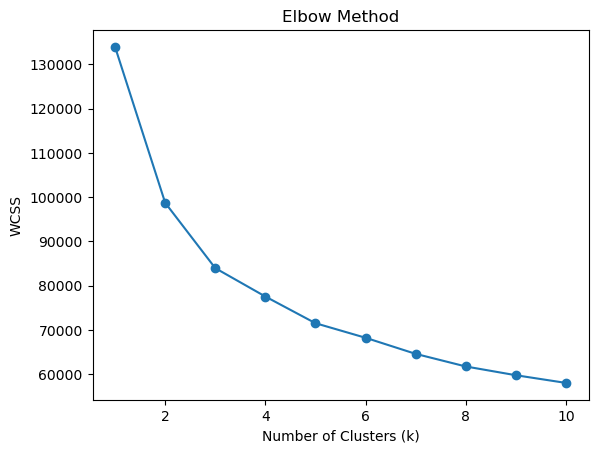

In [236]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.style.use('default')

features_cols = [
    'garman_klass_vol', 'rsi', 'bb_mid', 'bb_low', 'bb_high', 'atr', 'macd',
    'return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m', 'return_12m',
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'
]

# choose k based on elbow point

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_m)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [238]:
# cluster data into 3 clusters
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=3,
                             random_state=0,
                             init='random').fit(df).labels_
    return df

clustered_X_m = X_m.dropna().groupby('date',group_keys=False).apply(get_clusters)

Explained variance ratio (3D): [0.34908847 0.19318707 0.12525674]
Total variance explained: 66.75%


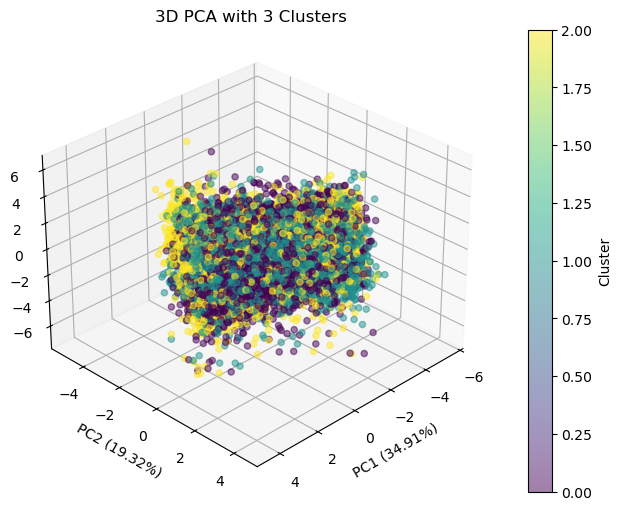

Cluster Summary for k=3:
         garman_klass_vol     rsi  bb_mid  bb_low  bb_high     atr    macd  \
cluster                                                                      
0                  0.0123  0.0708  0.3453  0.2769   0.3830  0.0820  0.1138   
1                  0.0088  0.1413  0.5088  0.4634   0.4095  0.0922  0.2254   
2                  0.0104 -0.0592  0.6447  0.5339   0.6114  0.4548  0.0132   

         return_1m  return_2m  return_3m  return_6m  return_9m  return_12m  \
cluster                                                                      
0           0.0128     0.0078     0.0085     0.0072     0.0068      0.0065   
1           0.0196     0.0165     0.0151     0.0116     0.0099      0.0087   
2           0.0102     0.0112     0.0102     0.0120     0.0126      0.0133   

         Mkt-RF     SMB     HML     RMW     CMA  
cluster                                          
0        1.0151  0.0834  0.1384  0.0014  0.0633  
1        1.0021  0.0592  0.0690  0.0215  0.

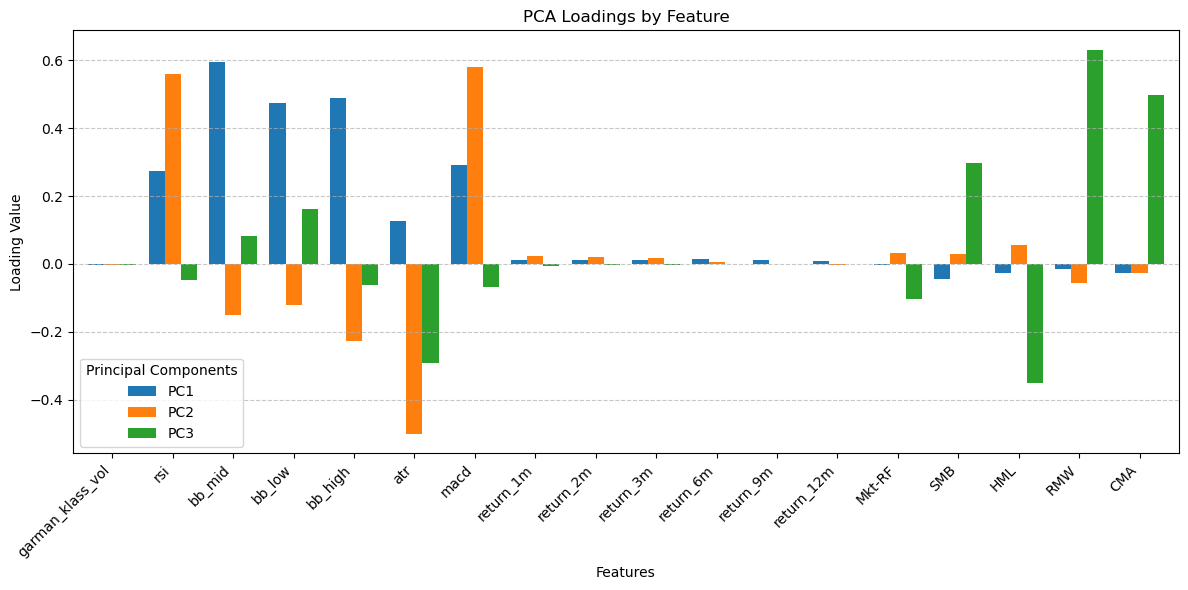

In [240]:
# Visualize data
from sklearn.decomposition import PCA

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(clustered_X_m[features_cols])
print(f"Explained variance ratio (3D): {pca_3d.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_3d.explained_variance_ratio_)*100:.2f}%")

# 3D plot
plot_data = pd.DataFrame(pca_result_3d, index=clustered_X_m.index, columns=['pca1', 'pca2', 'pca3'])
plot_data['cluster'] = clustered_X_m['cluster']

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(plot_data['pca1'], plot_data['pca2'], plot_data['pca3'], 
                     c=plot_data['cluster'], cmap='viridis', alpha=0.5)
ax.set_title('3D PCA with 3 Clusters')
ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.2f}%)')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.2f}%)')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.2f}%)')
plt.colorbar(scatter, label='Cluster')
ax.view_init(30, 45)
plt.show()

# Cluster Summary
cluster_summary = clustered_X_m.groupby('cluster')[features_cols].mean().round(4)
print("Cluster Summary for k=3:")
print(cluster_summary)

# Loadings SUmmary
loadings = pd.DataFrame(pca_3d.components_.T, index=features_cols, columns=['PC1', 'PC2', 'PC3'])
print("PCA Loadings:")
print(loadings.round(4))

# Bar Plot
loadings.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('PCA Loadings by Feature')
plt.xlabel('Features')
plt.ylabel('Loading Value')
plt.legend(title='Principal Components')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Select stocks based on clustering results

In [259]:
# Cluster Analysis (k=3)
# - Cluster 0 (Stable Value): 
        # Moderate volatility (garman_klass_vol = 0.0123)
        # modest rsi (0.0708)
        # lower Bollinger Band values (bb_mid = 0.3453, atr = 0.0820)
        # indicate stability
        # Returns are steady (1-month = 0.0128, 12-month = 0.0065)
        # value tilt (HML = 0.1384)
        # Ideal for conservative investors.
# - Cluster 1 (Momentum Growth): 
        # Lowest volatility (garman_klass_vol = 0.0088)
        # high rsi (0.1413)
        # strong macd (0.2254) 
        # signal momentum
        # Best short-term returns (1-month = 0.0196, 3-month = 0.0151)
        # fading long-term (12-month = 0.0087)
        # High CMA (0.1689) 
        # suggests profitability
        # Great for short-term gains
# - Cluster 2 (Volatile Long-Term): 
        # Average volatility (garman_klass_vol = 0.0104)
        # negative rsi (-0.0592)
        # high atr (0.4548) 
        # reflect risk and variability
        # Weak momentum (macd = 0.0132) 
        # but top long-term returns (12-month = 0.0133)
        # Suits risk-tolerant, long-term investors

# PCA Insights: PC1 (bb_mid = 0.5958) drives price level separation
# PC2 (rsi = 0.5604, macd = 0.5798, atr = -0.5015) contrasts momentum and volatility
# PC3 (RMW = 0.6315, CMA = 0.4989) highlights factor influences

# Cluster 1 is recommended 
        # Its low volatility, strong momentum, and superior short-term returns (1-month = 0.0196) 
        # offer a compelling mix of growth and stability, ideal for quick wins with moderate risk
        # Cluster 2’s long-term edge is offset by higher volatility.

#### if we choose cluster 1

In [242]:
best_cluster = 1
data_filterd = clustered_X_m[clustered_X_m['cluster'] == best_cluster].copy(deep=True)
data_filterd = data_filterd.reset_index(level='ticker')
# invest last month stock selection in next month
data_filterd.index = data_filterd.index+pd.DateOffset(1)
data_filterd = data_filterd.reset_index().set_index(['date', 'ticker'])
# create the stock pick list
dates = data_filterd.index.get_level_values('date').unique().tolist()
stock_picks = {}
for d in dates:
    stock_picks[d.strftime('%Y-%m-%d')] = data_filterd.xs(d, level='date').index.to_list()

### Portfolio optimization function

In [245]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0, upper_bound=1, risk_free_rate=0.0):
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns, 
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, upper_bound), # ensure portfolio is diversified enough
                           solver='SCS')

    # Check if any return exceeds risk-free rate
    if max(returns) > risk_free_rate:
        weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
        # print(f"Optimized for max Sharpe with risk-free rate {risk_free_rate}")
    else:
        weights = ef.min_volatility()
        # print("All returns below risk-free rate; optimized for min volatility")
    
    return ef.clean_weights()

In [247]:
stocks = data_month.index.get_level_values('ticker').unique().to_list()
new_df = yf.download(tickers=stocks,
                     start=data_month.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data_month.index.get_level_values('date').unique()[-1])

[*********************100%***********************]  164 of 164 completed


In [248]:
returns_df = np.log(new_df['Close']).diff()
portfolio_df = pd.DataFrame()

for st_date in stock_picks.keys():
    ed_date = (pd.to_datetime(st_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    # required one year prior return for optimization
    # !! historical data might not do a good job on return estimation !!
    opt_st_date = (pd.to_datetime(st_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    opt_ed_date = (pd.to_datetime(st_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
    cols = stock_picks[st_date]
    opt_df = new_df.loc[opt_st_date:opt_ed_date]['Close'][cols]

    success = False
    try:
        #lower bound = half of equal weight (changable)
        lower_bound = round((1/len(opt_df.columns))*0.5,4)
        upper_bound = 0.1
        weights = optimize_weights(prices=opt_df, lower_bound=lower_bound, upper_bound=upper_bound)
        weights = pd.DataFrame(weights, index=pd.Series(0))
        success = True
    except:
        print(f'Max Sharpe Opt failed for {st_date}, continuing with Equal Weight')
    if not success:
        weights = pd.DataFrame([1/len(opt_df.columns) for i in range(len(opt_df.columns))],
                               index=opt_df.columns.to_list(),
                               columns=pd.Series(0)).T
        
    weights = weights.stack().to_frame('weight').reset_index(level=0, drop=True)
    tmp_df = returns_df[st_date:ed_date]
    tmp_df = tmp_df.stack().to_frame('return').reset_index(level='Date')
    tmp_df = tmp_df.merge(weights, left_index=True, right_index=True).reset_index().set_index(['Date', 'Ticker'])
    
    tmp_df['weighted_return'] = tmp_df['return']*tmp_df['weight']
    tmp_df = tmp_df.groupby(level='Date')['weighted_return'].sum().to_frame('first strat return')
    portfolio_df = pd.concat([portfolio_df, tmp_df], axis=0)

Max Sharpe Opt failed for 2019-06-01, continuing with Equal Weight
Max Sharpe Opt failed for 2020-08-01, continuing with Equal Weight
Max Sharpe Opt failed for 2020-11-01, continuing with Equal Weight
Max Sharpe Opt failed for 2020-12-01, continuing with Equal Weight
Max Sharpe Opt failed for 2022-08-01, continuing with Equal Weight
Max Sharpe Opt failed for 2022-10-01, continuing with Equal Weight
Max Sharpe Opt failed for 2022-11-01, continuing with Equal Weight
Max Sharpe Opt failed for 2023-01-01, continuing with Equal Weight
Max Sharpe Opt failed for 2023-02-01, continuing with Equal Weight
Max Sharpe Opt failed for 2023-03-01, continuing with Equal Weight
Max Sharpe Opt failed for 2023-09-01, continuing with Equal Weight
Max Sharpe Opt failed for 2023-11-01, continuing with Equal Weight
Max Sharpe Opt failed for 2023-12-01, continuing with Equal Weight
Max Sharpe Opt failed for 2024-02-01, continuing with Equal Weight
Max Sharpe Opt failed for 2024-06-01, continuing with Equal We

### Visualize portfolio returns and benchmark

In [250]:
spy = yf.download(tickers='SPY', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [251]:
spy_ret = np.log(spy['Close']).diff().dropna()
compare_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

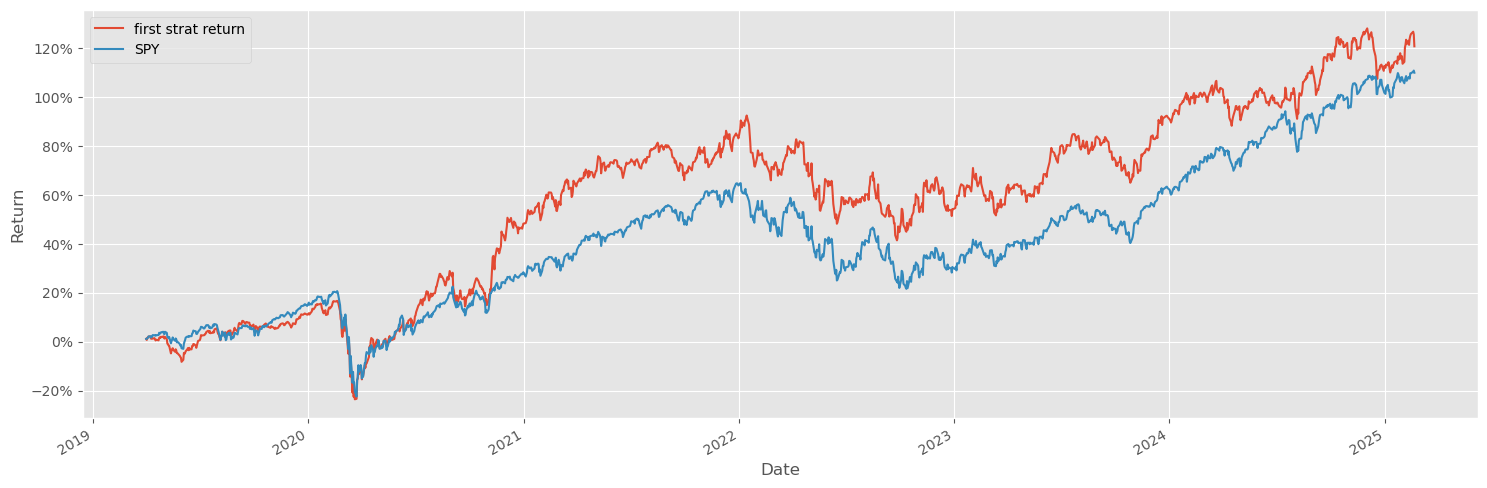

In [252]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

compare_cum_ret = np.expm1(np.log1p(compare_df).cumsum())

compare_cum_ret.plot(figsize=(18,6))

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()